In [1]:
import string
import numpy as np
import re
import networkx
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import itertools

In [2]:
fhr = open('amazon-meta.txt', 'r', encoding='utf-8', errors='ignore')


columns = ['Title', 'Categories', 'Group', 'SalesRank', 'TotalReviews', 'AvgRating']
MetaData = dict(zip(columns, [[] for i in columns]))


(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
    ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
for line in tqdm(fhr):
    line = line.strip()
    # a product block started
    if(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((fhr.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ', Categories)
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    elif (line==""):
        try:
            MetaData['Title'].append(Title)
            MetaData['Categories'].append(' '.join(set(Categories.split())))
            MetaData['Group'].append(Group)
            MetaData['SalesRank'].append(int(SalesRank))
            MetaData['TotalReviews'].append(int(TotalReviews))
            MetaData['AvgRating'].append(float(AvgRating))
        except NameError as err:
            print(err)
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
            ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
fhr.close()

12500875it [02:28, 84425.84it/s] 


In [3]:
import pandas as pd

md_df = pd.DataFrame(MetaData)

In [4]:
md_df.columns

Index(['Title', 'Categories', 'Group', 'SalesRank', 'TotalReviews',
       'AvgRating'],
      dtype='object')

In [5]:
md_df.Title.value_counts()

                                                                                                                                                                       5869
Live                                                                                                                                                                    113
Best of                                                                                                                                                                 106
Anthology                                                                                                                                                                85
Ultimate Collection                                                                                                                                                      79
Super Hits                                                                                                                                  

In [6]:
md_df.Categories

0                                                          
1                                                          
2         spirituality christianity books sermons religi...
3         spirituality earth religions books witchcraft ...
4         hobbies home books crafts general garden subjects
5         sacred general other religion translations liv...
6         spirituality christianity business books worsh...
7         united books arts photo jewish nonfiction gene...
8         jazz music specialty imports stores general st...
9         lesbian criminology books s nonfiction general...
10            cooking food books bread wine subjects baking
11        politics anthropology books social nonfiction ...
12        medicine medical specialty books holistic prof...
13        loss general condiments fat cooking nutrition ...
14        fantasy books general theory literature scienc...
15         jazz music specialty indie stores general styles
16        drama united authors books art

In [7]:
md_df.Group.value_counts()

Book            393561
Music           103144
Video            26131
DVD              19828
                  5869
Toy                  8
Software             5
CE                   4
Video Games          1
Sports               1
Baby Product         1
Name: Group, dtype: int64

(array([313049., 119805.,  56721.,  27523.,  13101.,   7070.,   4426.,
          2850.,   3248.,    760.]),
 array([-1.0000000e+00,  3.7983420e+05,  7.5966940e+05,  1.1395046e+06,
         1.5193398e+06,  1.8991750e+06,  2.2790102e+06,  2.6588454e+06,
         3.0386806e+06,  3.4185158e+06,  3.7983510e+06]),
 <a list of 10 Patch objects>)

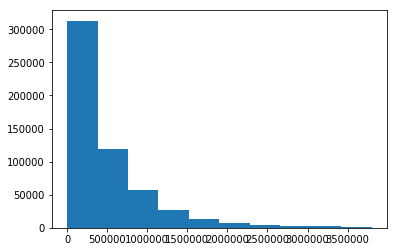

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(md_df.SalesRank)

(array([6.37100e+03, 9.00000e+00, 1.06000e+02, 6.12000e+02, 3.14600e+03,
        1.50980e+04, 5.90130e+04, 1.27225e+05, 2.35219e+05, 1.01754e+05]),
 array([ 0.        ,  1.51500781,  3.03001562,  4.54502343,  6.06003124,
         7.57503905,  9.09004687, 10.60505468, 12.12006249, 13.6350703 ,
        15.15007811]),
 <a list of 10 Patch objects>)

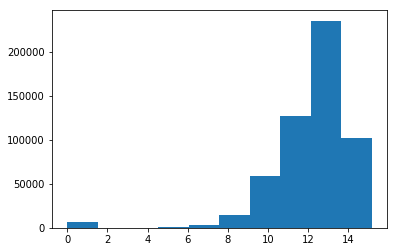

In [9]:
plt.hist(np.log(md_df.SalesRank + 2))

(array([2.26858e+05, 1.28288e+05, 9.94340e+04, 5.07940e+04, 2.45780e+04,
        1.14080e+04, 4.97000e+03, 1.70800e+03, 4.28000e+02, 8.70000e+01]),
 array([0.        , 0.86208322, 1.72416645, 2.58624967, 3.44833289,
        4.31041611, 5.17249934, 6.03458256, 6.89666578, 7.758749  ,
        8.62083223]),
 <a list of 10 Patch objects>)

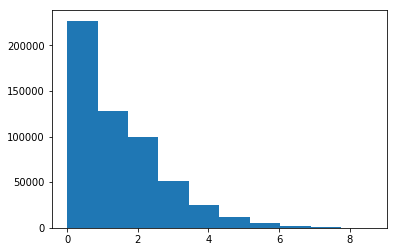

In [10]:
plt.hist(np.log(md_df.TotalReviews.values + 1))

(array([145818.,      0.,   2732.,    837.,   4117.,   6561.,  21227.,
         34405.,  83458., 249398.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

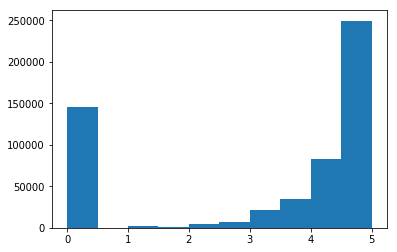

In [11]:
plt.hist(md_df.AvgRating)

In [12]:
"""
is_Book, is_Music, is_Video_or_DVD, np.log(SalesRank + 2), np.log(TotalReviews), AvgRating
"""

is_book = md_df.Group == 'Book'
is_music = md_df.Group == 'Music'
is_video = (md_df.Group == 'Video') | (md_df.Group == 'DVD')
logrank = np.log(-md_df.SalesRank.min() + md_df.SalesRank + 1)
logrev = np.log(-md_df.TotalReviews.min() + md_df.TotalReviews + 1)
avg_rating = md_df.AvgRating

In [13]:
columns = (is_book, is_music, is_video, logrank, logrev, avg_rating)
matrix = np.vstack(columns).T
matrix.shape

(548553, 6)

In [14]:
matrix = (matrix - matrix.mean(axis=0).reshape(1, -1)) / matrix.std(axis=0).reshape(1, -1)

In [15]:
matrix.mean(axis=0), matrix.std(axis=0)

(array([ 2.81858087e-17,  7.79254712e-17, -2.65278200e-17, -8.25678397e-16,
         2.45382335e-16,  6.13455837e-17]), array([1., 1., 1., 1., 1., 1.]))

In [16]:
matrix += np.random.randn(*matrix.shape) * 1e-4

In [17]:
with open("metadata/amazon", "w") as f:
    for row in matrix:
        for elem in row:
            print("%.8f" % elem, end=' ', file=f)
        print(file=f)